In [1]:
import matplotlib.pyplot as plt
import networkx as nx 
import numpy as np

import severability

from mcf import SBM

# Multiscale severability applied to 2-scale SBM

In [2]:
# define number of nodes
N = 27 * 4

# define block sizes for different scales
n_blocks_msbm_c = 3
n_blocks_msbm_f = 9

# set probability of edges within and between blocks
msbm_p_in = 0.7
p_out = 0.001


In [3]:
# define ground truth partitions
coarse_scale_id = np.zeros(N)
fine_scale_id = np.zeros(N)

for i in range(N):
    coarse_scale_id[(i * N // n_blocks_msbm_c) : ((i + 1) * N // n_blocks_msbm_c)] = i

for i in range(n_blocks_msbm_f):
    fine_scale_id[(i * N // n_blocks_msbm_f) : ((i + 1) * N // n_blocks_msbm_f)] = i

# store ground truth partition in severability format
ground_truth_c = [[(list(np.argwhere(coarse_scale_id == i).flatten()), 1) for i in np.unique(coarse_scale_id)]]
ground_truth_f = [[(list(np.argwhere(fine_scale_id == i).flatten()), 1) for i in np.unique(fine_scale_id)]]


Expected number of edges: 474.272
Expected sparsity: 0.082


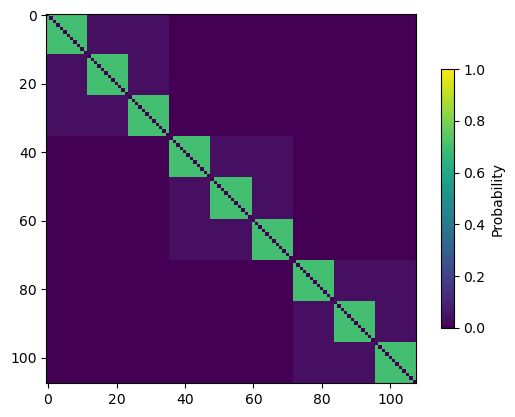

In [4]:
# define mSBM
msbm = SBM(N, seed=2)
msbm.add_level(n_blocks=n_blocks_msbm_c,p_in=msbm_p_in,p_out=p_out,weight=1)
msbm.add_level(n_blocks=n_blocks_msbm_f,p_in=msbm_p_in,p_out=p_out,weight=16)

print("Expected number of edges:", round(msbm.n_expected_edges,3))
print("Expected sparsity:",round(msbm.expected_sparsity,3))

# plot probability matrix
fig, ax = plt.subplots(1)
im = ax.imshow(msbm.P, vmin=0, vmax=1)
cbar = plt.colorbar(im,shrink=0.7)
cbar.set_label("Probability")

Graph with 108 nodes and 465 edges


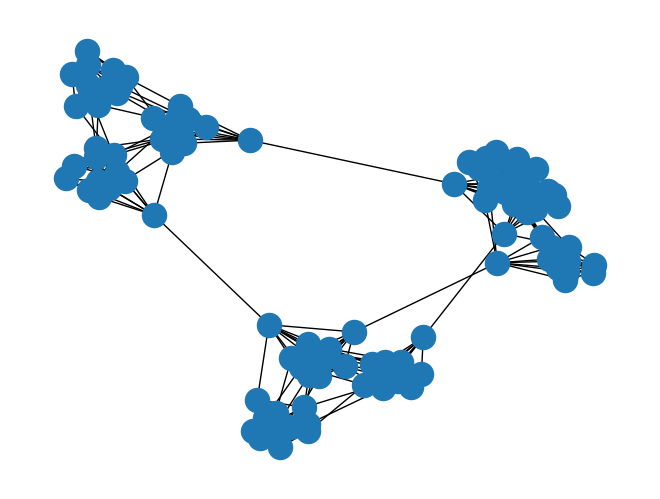

In [5]:
# sample adjacency matrix
A, _ = msbm.sample(with_shuffle=False)

# plot graph
G = nx.from_numpy_array(A)
print(G)
nx.draw(G)

In [6]:
# run multiscale severability
sev_results = severability.multiscale_severability(A, t_max=10, n_tries=30,  n_workers=7)

Optimise severability ...


100%|██████████| 5/5 [01:49<00:00, 21.85s/it]


Compute 1-Rand(t) ...


100%|██████████| 5/5 [01:53<00:00, 22.77s/it]


Compute 1-Rand(t,t') ...


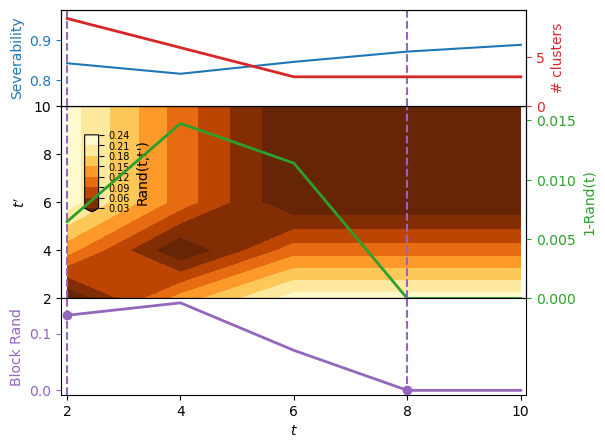

In [7]:
# plot severability results
sev_results = severability.identify_optimal_scales(sev_results, kernel_size=3)
severability.plotting.plot_scan(sev_results)

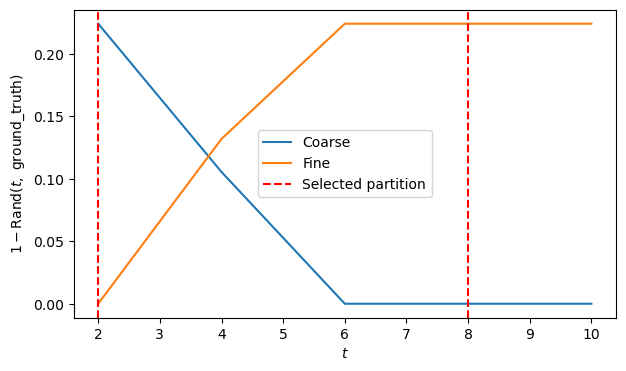

In [8]:
# compute 1-Rand[ground_truth, severability(t)]
rand_ground_truth_c = severability.compute_rand_ttprime(ground_truth_c+sev_results["partitions"], n_nodes=G.number_of_nodes())[:,0][1:]
rand_ground_truth_f = severability.compute_rand_ttprime(ground_truth_f+sev_results["partitions"], n_nodes=G.number_of_nodes())[:,0][1:]

# plot 
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(sev_results["scales"], rand_ground_truth_c, label="Coarse")
ax.plot(sev_results["scales"], rand_ground_truth_f, label="Fine")
ax.axvline(x=sev_results["scales"][sev_results["selected_partitions"][0]], ls = "--", c="red", label="Selected partition")
ax.axvline(x=sev_results["scales"][sev_results["selected_partitions"][1]], ls = "--", c="red")
ax.set(xlabel=r"$t$", ylabel="$1-\mathrm{Rand}(t,$ ground_truth$)$")
ax.legend();

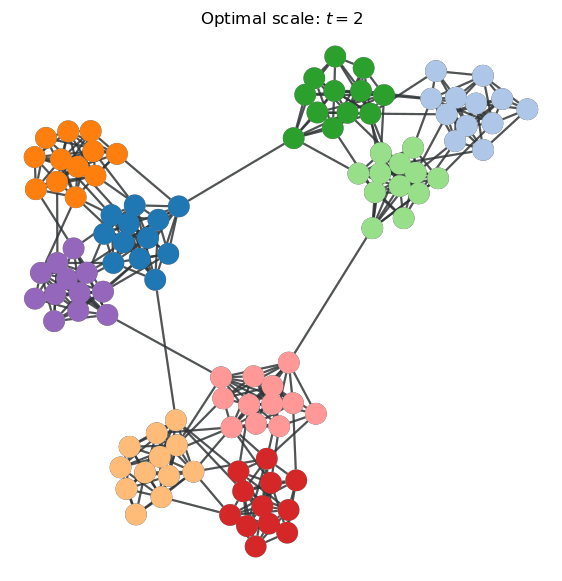

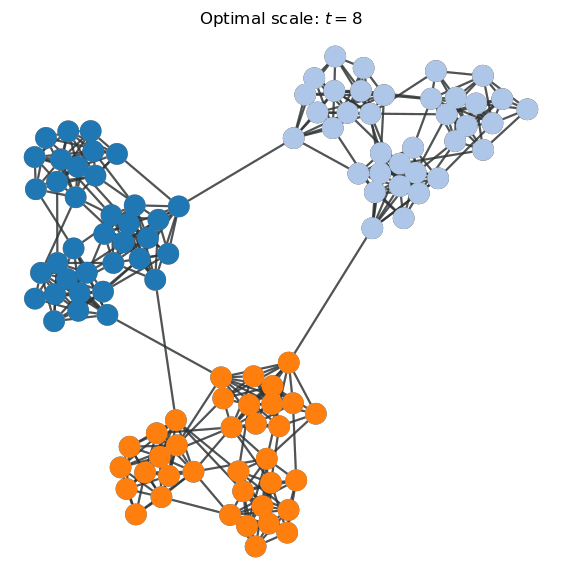

In [9]:
# create the pie chart graph visualisation
for i in sev_results["selected_partitions"]:
    severability.plot_pie_graph(sev_results['partitions'][i], A, title=f"Optimal scale: $t={sev_results['scales'][i]}$")